# Can we use local field potentials to predict trial stops?

In [1]:
import numpy as np
import pandas as pd
import physutils
import dbio
import os
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
np.random.seed(123456)

## Load Data

In [2]:
# which patient, dataset to plot
dtup = 18, 1

In [3]:
# load data
dbname = os.path.expanduser('data/bart.hdf5')
lfpraw = dbio.fetch_all_such_LFP(dbname, *dtup)

## Preprocess Data

In [4]:
lfp = lfpraw.demean()

In [5]:
filters = ['delta', 'theta', 'alpha', 'beta', 'gamma']
lfp = lfp.bandlimit(filters)

In [6]:
# decimate to 40 Hz, get instantaneous power, censor, and z-score each channel
lfp = lfp.decimate(5).instpwr().censor().zscore()

In [7]:
# get events
evt = dbio.fetch(dbname, 'events', *dtup)
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

## Get True Positives

In [8]:
truepos = pd.DataFrame(stops_free.values, columns=['time'])
truepos['outcome'] = 1

## Get True Negatives

We will choose as true negatives an equal number of random times that are not within a fixed interval of any true positives.

In [9]:
def within_range(test_value, anchor_list, radius_tuple):
    # return true when test_value is not within a radius tuple
    # of any value in anchor_list 
    # NOTE: both elements of radius_tuple must be positive!

    dist = test_value - np.array(anchor_list)
    within_range = np.logical_and(dist > -radius_tuple[0],
        dist < radius_tuple[1]) 
    return np.any(within_range)

In [10]:
Tpre = 2  # time before stop to exclude
Tpost = 1.5  # time after stop to exclude
dt = np.around(1. / lfp.meta['sr'], 3) 

In [11]:
maxT = lfp.index[-1]
Nrand = truepos.shape[0]  # number to generate: same as number of true positives
Ncand = 2000  # number to filter down to Nrand
candidates = np.random.rand(Ncand) * (maxT - Tpre) + Tpre
candidates = np.around(candidates / dt) * dt  # round to nearest dt
candidates = np.unique(candidates)
np.random.shuffle(candidates)
rand_times = filter(lambda x: ~within_range(x, truepos['time'], 
                                            (Tpre, Tpost)), candidates)[:Nrand]
trueneg = pd.DataFrame(rand_times, columns=['time'])
trueneg['outcome'] = 0

## Concatenate true and false positives together to form training labels:

In [12]:
allevt = pd.concat([truepos, trueneg])
allevt['time'] = np.around(allevt['time'] / dt) * dt
allevt = allevt.set_index('time')

## Grab band-averaged power prior to each event

In [13]:
meanpwr = pd.rolling_mean(lfp.dataframe, np.ceil(np.abs(Tpre) / dt), min_periods=1)
meanpwr.index = np.around(meanpwr.index / dt) * dt

In [14]:
trainset = pd.concat([allevt, meanpwr], axis=1, join='inner')
trainset = trainset.dropna()  # can't send glmnet any row with a NaN

## Run sparse regression in R

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R
set.seed(77654)
suppressMessages(library(glmnet))
source('glm_helpers.R')

In [17]:
%Rpush trainset
%R fitobj <- run_glm(data.matrix(trainset), measure='auc');

<img src="auc.svg"/>

In [18]:
%%R -o auc
source('helpers.R')

# get performance
glmobj <- fitobj$glmobj
min.ind <- which(glmobj$lambda == glmobj$lambda.1se)
auc <- glmobj$cvm[min.ind]

In [19]:
print "Area Under the Curve = {}".format(auc)

Area Under the Curve = [ 0.746642]


In [20]:
%%R -o coef_grid
source('helpers.R')
df <- extract_coeffs(fitobj)

# now reorder channels based on hierarchical clustering
coef_grid <- as.data.frame(cast(df, channel ~ band))

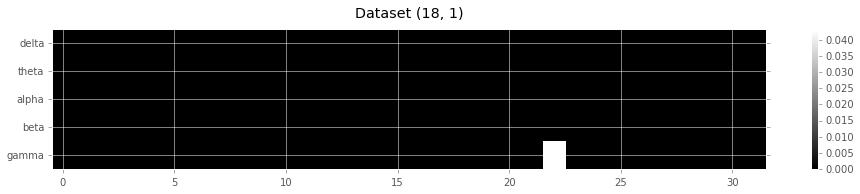

In [21]:
cg = coef_grid
plt.matshow(np.abs(cg.values[:, 1:].T), aspect='auto', cmap='gray');
plt.yticks(range(len(filters)), filters);
plt.colorbar();
plt.gca().xaxis.tick_bottom()
plt.gca().xaxis.set_label_position('bottom') 
plt.title('Dataset ({}, {})'.format(*dtup));

In [22]:
cg

,channel,delta,theta,alpha,beta,gamma
0,1,0,0,0,0,0.00000
1,2,0,0,0,0,0.00000
2,3,0,0,0,0,0.00000
3,4,0,0,0,0,0.00000
4,5,0,0,0,0,0.00000
5,6,0,0,0,0,0.00000
6,7,0,0,0,0,0.00000
7,8,0,0,0,0,0.00000
8,9,0,0,0,0,0.00000
9,10,0,0,0,0,0.00000
